In [1]:
!nvidia-smi

Thu Feb  5 02:30:36 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install sacrebleu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 6.2 MB/s eta 0:00:00


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM
from torch.optim import AdamW
import sacrebleu
import numpy as np
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import os

In [4]:

# Model and Tokenizer Initialization
checkpoint = "Langboat/mengzi-t5-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint,use_fast=False)
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(
    model.parameters(),
    lr=5e-5
)
print(f'Using {device} device')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/725k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/282 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Using cuda device


In [5]:
# example of pre trained model
text = "今天天气 <extra_id_0>。"

inputs = tokenizer(text, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_length=32
    )

print("RAW:", tokenizer.decode(outputs[0], skip_special_tokens=False))
print("CLEAN:", tokenizer.decode(outputs[0], skip_special_tokens=True))

RAW: <pad><extra_id_0>晴<extra_id_1></s>
CLEAN: 晴


In [6]:
def seed_everything(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
seed_everything(42)

Using cuda device


In [7]:

# Dataset
class QADataset(Dataset):
    def __init__(self, data_file):
        self.data = []
        with open(data_file, "r", encoding="utf-8") as f:
            for line in f:
                self.data.append(json.loads(line.strip()))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def make_collate_fn(tokenizer, max_length=256):
    def collate_fn(batch_samples):
        batch_inputs = []
        batch_targets = []

        for sample in batch_samples:
            question = sample["question"]
            context = sample["context"]
            answer = sample["answer"]

            input_text = f"question: {question} context: {context}"

            batch_inputs.append(input_text)
            batch_targets.append(answer)

        batch_data = tokenizer(
            batch_inputs,
            text_target=batch_targets,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

        return batch_data

    return collate_fn

In [13]:
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0

    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    return total_loss / len(dataloader)


def char_tokenize(s):
    return s.split()


def eval_bleu(model, dataloader, tokenizer, device, max_gen_length=32):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}

            generated_ids = model.generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_length=max_gen_length,
            )

            decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            labels = batch["labels"]
            labels = torch.where(labels != -100, labels, tokenizer.pad_token_id)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            all_preds.extend([p.strip() for p in decoded_preds])
            all_labels.extend([[l.strip()] for l in decoded_labels])

    # 格式：all_preds = ['text1', 'text2', ...]
    #      all_labels = [['ref1'], ['ref2'], ...]
    bleu = sacrebleu.corpus_bleu(all_preds, all_labels, smooth_method="exp", tokenize='zh')

    return {
        "BLEU-1": bleu.precisions[0] ,
        "BLEU-2": bleu.precisions[1],
        "BLEU-3": bleu.precisions[2] ,
        "BLEU-4": bleu.precisions[3],
    }


def inference(model, tokenizer, question, context, device, max_gen_length=32, num_beams=4):
    """
    Run inference on a single QA example.
    """
    model.eval()

    input_text = f"question: {question} context: {context}"

    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        max_length=512,
    ).to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=max_gen_length,
            num_beams=num_beams,
            early_stopping=True,
        )

    answer = tokenizer.decode(
        generated_ids[0],
        skip_special_tokens=True
    )

    return answer.strip()


def save_checkpoint(
    model,
    tokenizer,
    optimizer,
    epoch,
    save_dir,
    bleu_score=None,
    is_best=False,
):
    os.makedirs(save_dir, exist_ok=True)

    ckpt_dir = os.path.join(save_dir, f"checkpoint-epoch-{epoch}")
    os.makedirs(ckpt_dir, exist_ok=True)

    # 保存模型 & tokenizer（HF 标准）
    model.save_pretrained(ckpt_dir)
    tokenizer.save_pretrained(ckpt_dir)

    # 保存训练状态
    torch.save(
        {
            "epoch": epoch,
            "optimizer": optimizer.state_dict(),
            "bleu": bleu_score,
        },
        os.path.join(ckpt_dir, "training_state.pt"),
    )

    # 方便 resume：额外保存一个 last
    last_dir = os.path.join(save_dir, "last")
    model.save_pretrained(last_dir)
    tokenizer.save_pretrained(last_dir)
    torch.save(
        {
            "epoch": epoch,
            "optimizer": optimizer.state_dict(),
            "bleu": bleu_score,
        },
        os.path.join(last_dir, "training_state.pt"),
    )

    # 可选：保存 best
    if is_best:
        best_dir = os.path.join(save_dir, "best")
        model.save_pretrained(best_dir)
        tokenizer.save_pretrained(best_dir)
        torch.save(
            {
                "epoch": epoch,
                "optimizer": optimizer.state_dict(),
                "bleu": bleu_score,
            },
            os.path.join(best_dir, "training_state.pt"),
        )


def load_checkpoint(
    ckpt_dir,
    model,
    optimizer,
    device,
):
    model = model.from_pretrained(ckpt_dir)
    model.to(device)

    state = torch.load(
        os.path.join(ckpt_dir, "training_state.pt"),
        map_location=device,
    )

    optimizer.load_state_dict(state["optimizer"])
    start_epoch = state["epoch"] + 1

    print(f"Resumed from {ckpt_dir}, start_epoch={start_epoch}")
    return model, optimizer, start_epoch


def load_checkpoint(
    ckpt_dir,
    model,
    optimizer,
    device,
):
    model = model.from_pretrained(ckpt_dir)
    model.to(device)

    state = torch.load(
        os.path.join(ckpt_dir, "training_state.pt"),
        map_location=device,
    )

    optimizer.load_state_dict(state["optimizer"])
    start_epoch = state["epoch"] + 1

    print(f"Resumed from {ckpt_dir}, start_epoch={start_epoch}")
    return model, optimizer, start_epoch




In [9]:
# load data
collate_fn = make_collate_fn(tokenizer, max_length=256)

train_dataset = QADataset("/content/data/dev.json")
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)

valid_dataset = QADataset("/content/data/dev.json")
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)

In [14]:
num_epochs = 10
save_dir = "/content/checkpoints"

train_losses = []
bleu1_scores = []
bleu2_scores = []
bleu3_scores = []
bleu4_scores = []

best_bleu4 = -1.0
start_epoch = 0

# ====== 如果要 resume（可选）======
resume_ckpt = None  # 例如 "checkpoints/last"
if resume_ckpt is not None:
    model, optimizer, start_epoch = load_checkpoint(
        resume_ckpt,
        model,
        optimizer,
        device,
    )

# ====== Training loop ======
for epoch in range(start_epoch, num_epochs):
    print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")

    # 1️⃣ Train
    train_loss = train_one_epoch(
        model=model,
        dataloader=train_dataloader,
        optimizer=optimizer,
        device=device,
    )
    train_losses.append(train_loss)

    # 2️⃣ Eval
    bleu_scores = eval_bleu(
        model=model,
        dataloader=valid_dataloader,
        tokenizer=tokenizer,
        device=device,
    )

    bleu1_scores.append(bleu_scores["BLEU-1"])
    bleu2_scores.append(bleu_scores["BLEU-2"])
    bleu3_scores.append(bleu_scores["BLEU-3"])
    bleu4_scores.append(bleu_scores["BLEU-4"])

    # 3️⃣ Log
    print(f"Train Loss: {train_loss:.4f}")
    print(
        f"BLEU-1: {bleu_scores['BLEU-1']:.2f} | "
        f"BLEU-2: {bleu_scores['BLEU-2']:.2f} | "
        f"BLEU-3: {bleu_scores['BLEU-3']:.2f} | "
        f"BLEU-4: {bleu_scores['BLEU-4']:.2f}"
    )

    # 4️⃣ Checkpoint
    current_bleu4 = bleu_scores["BLEU-4"]
    is_best = current_bleu4 > best_bleu4
    if is_best:
        best_bleu4 = current_bleu4

    save_checkpoint(
        model=model,
        tokenizer=tokenizer,
        optimizer=optimizer,
        epoch=epoch,
        save_dir=save_dir,
        bleu_score=current_bleu4,
        is_best=is_best,
    )



===== Epoch 1/10 =====


Evaluating: 100%|██████████| 123/123 [01:13<00:00,  1.67it/s]

Train Loss: 8.1036
BLEU-1: 100.00 | BLEU-2: 50.00 | BLEU-3: 0.00 | BLEU-4: 0.00


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


===== Epoch 2/10 =====


Evaluating: 100%|██████████| 123/123 [01:27<00:00,  1.40it/s]

Train Loss: 7.7329
BLEU-1: 100.00 | BLEU-2: 100.00 | BLEU-3: 66.67 | BLEU-4: 50.00


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


===== Epoch 3/10 =====


Evaluating: 100%|██████████| 123/123 [01:27<00:00,  1.40it/s]

Train Loss: 7.3492
BLEU-1: 100.00 | BLEU-2: 50.00 | BLEU-3: 50.00 | BLEU-4: 0.00


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


===== Epoch 4/10 =====


Evaluating: 100%|██████████| 123/123 [01:32<00:00,  1.33it/s]

Train Loss: 6.9579
BLEU-1: 100.00 | BLEU-2: 100.00 | BLEU-3: 100.00 | BLEU-4: 0.00


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


===== Epoch 5/10 =====


Evaluating: 100%|██████████| 123/123 [01:29<00:00,  1.37it/s]

Train Loss: 6.5549
BLEU-1: 33.33 | BLEU-2: 25.00 | BLEU-3: 25.00 | BLEU-4: 0.00


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


===== Epoch 6/10 =====


Evaluating: 100%|██████████| 123/123 [01:25<00:00,  1.44it/s]

Train Loss: 6.1569
BLEU-1: 0.00 | BLEU-2: 0.00 | BLEU-3: 0.00 | BLEU-4: 0.00


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


===== Epoch 7/10 =====


Evaluating: 100%|██████████| 123/123 [01:25<00:00,  1.45it/s]

Train Loss: 5.7603
BLEU-1: 75.00 | BLEU-2: 100.00 | BLEU-3: 25.00 | BLEU-4: 25.00


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


===== Epoch 8/10 =====


Evaluating: 100%|██████████| 123/123 [01:31<00:00,  1.35it/s]

Train Loss: 5.4207
BLEU-1: 100.00 | BLEU-2: 33.33 | BLEU-3: 25.00 | BLEU-4: 25.00


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


===== Epoch 9/10 =====


Evaluating: 100%|██████████| 123/123 [01:35<00:00,  1.29it/s]

Train Loss: 5.0523
BLEU-1: 0.00 | BLEU-2: 0.00 | BLEU-3: 0.00 | BLEU-4: 0.00


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


===== Epoch 10/10 =====


Evaluating: 100%|██████████| 123/123 [01:35<00:00,  1.28it/s]

Train Loss: 4.7106
BLEU-1: 100.00 | BLEU-2: 0.00 | BLEU-3: 0.00 | BLEU-4: 0.00


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

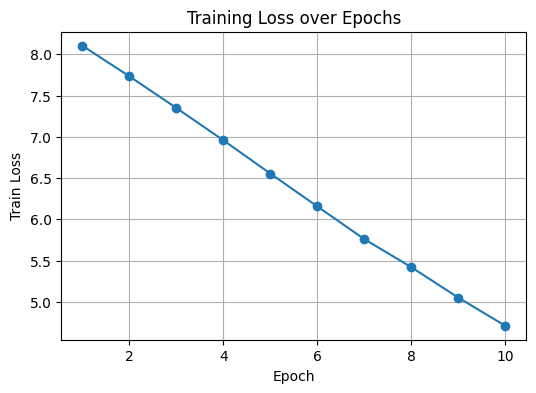

In [15]:
#plot training loss
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()

In [16]:
# Save final model
final_save_dir = "/content/checkpoints/final"

model.save_pretrained(final_save_dir)
tokenizer.save_pretrained(final_save_dir)

print(f"Final model saved to {final_save_dir}")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Final model saved to /content/checkpoints/final


In [17]:
# load final model
model = AutoModelForSeq2SeqLM.from_pretrained(final_save_dir)
tokenizer = AutoTokenizer.from_pretrained(final_save_dir)
model.to(device)

Loading weights:   0%|          | 0/282 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [25]:
train_dataset[0]

{'context': '年基准利率4.35%。 从实际看,贷款的基本条件是: 一是中国大陆居民,年龄在60岁以下; 二是有稳定的住址和工作或经营地点; 三是有稳定的收入来源; 四是无不良信用记录,贷款用途不能作为炒股,赌博等行为; 五是具有完全民事行为能力。',
 'answer': '年基准利率4.35%',
 'question': '2017年银行贷款基准利率',
 'id': 0}

In [30]:

# inference example
question = train_dataset[0]['question']
context = train_dataset[0]['context']

pred = inference(
    model=model,
    tokenizer=tokenizer,
    question=question,
    context=context,
    device=device,
    max_gen_length=64,
    num_beams=5,
)

print("Predicted answer:", pred)

Predicted answer: 
